Missing values after imputation:
 DATETIME          0
SYMBOL            0
OPEN              0
HIGH              0
LOW               0
CLOSE             0
VOLUME            0
PREVIOUS_CLOSE    0
CHANGE            0
CHANGE_PERCENT    0
LOW_CLOSE         0
HIGH_CLOSE        0
TOTAL             0
GAP               0
INTERVAL          0
dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13772\2398847726.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["DATETIME"] = pd.to_datetime(df1["DATETIME"],dayfirst=True) #dayfirst menas =dd mm yy


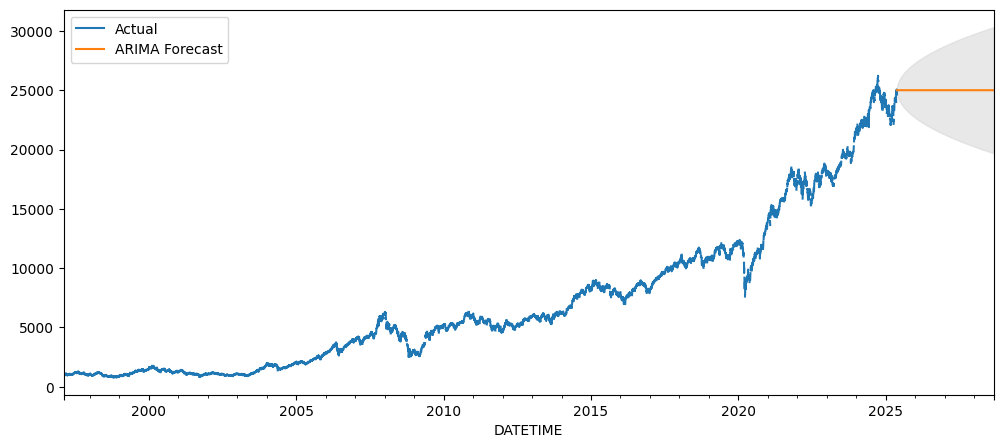

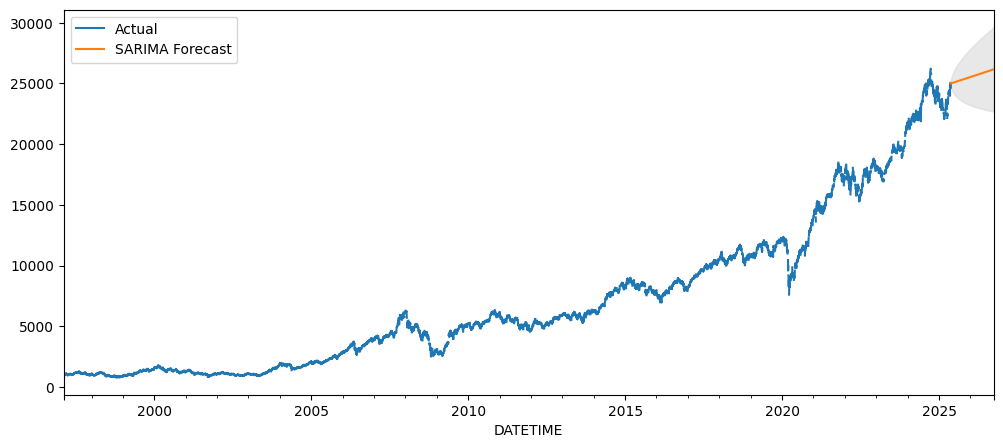

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

df = pd.read_csv("D:/projects/zidio/NSE_Daily_indices_data.csv")
#print(df.head())
check = df.isnull().sum()

# Step 1: Backfill first row if NaN
for col in df.columns:
    if pd.isna(df[col].iloc[0]):
        df.at[df.index[0], col] = df[col].bfill().iloc[0]

# Step 2: Rolling mean on numeric data only
num_cols = df.select_dtypes(include='number').columns
rolling_means = df[num_cols].rolling(window=5, min_periods=1).mean()
df[num_cols] = df[num_cols].fillna(rolling_means)

print("Missing values after imputation:\n", df.isnull().sum())

df1 = df

df1 = df1[df1['SYMBOL'] == 'NIFTY']

#convert date str to datetime foramt and index correct
df1["DATETIME"] = pd.to_datetime(df1["DATETIME"],dayfirst=True) #dayfirst menas =dd mm yy
df1.set_index('DATETIME',inplace=True)

df1 = df1.groupby(df1.index).mean(numeric_only=True) #any missing value date la group by pannum
df1 = df1.sort_index()
df1 = df1.asfreq("D")#set freq daily
df1 = df1.asfreq("D",method="ffill") #some misising data

close = df1['CLOSE']
model = ARIMA(close, order=(1,1,1)).fit()
pred = model.get_forecast(steps=1200)
fc = pred.predicted_mean
ci = pred.conf_int()

plt.figure(figsize=(12,5))
close.plot(label='Actual')
fc.plot(label='ARIMA Forecast')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend()
plt.show()

# SARIMA with seasonality (yearly)
model_s = SARIMAX(close, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
pred_s = model_s.get_forecast(steps=500)
fc_s = pred_s.predicted_mean
ci_s = pred_s.conf_int()

plt.figure(figsize=(12,5))
close.plot(label='Actual')
fc_s.plot(label='SARIMA Forecast')
plt.fill_between(ci_s.index, ci_s.iloc[:,0], ci_s.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend()
plt.show()


ADF Statistic: 2.1327457208508878 p-value: 0.9988224471708149
Series is non-stationary. Consider differencing.
ADF p-value after 1st diff: 1.5810149460100405e-29


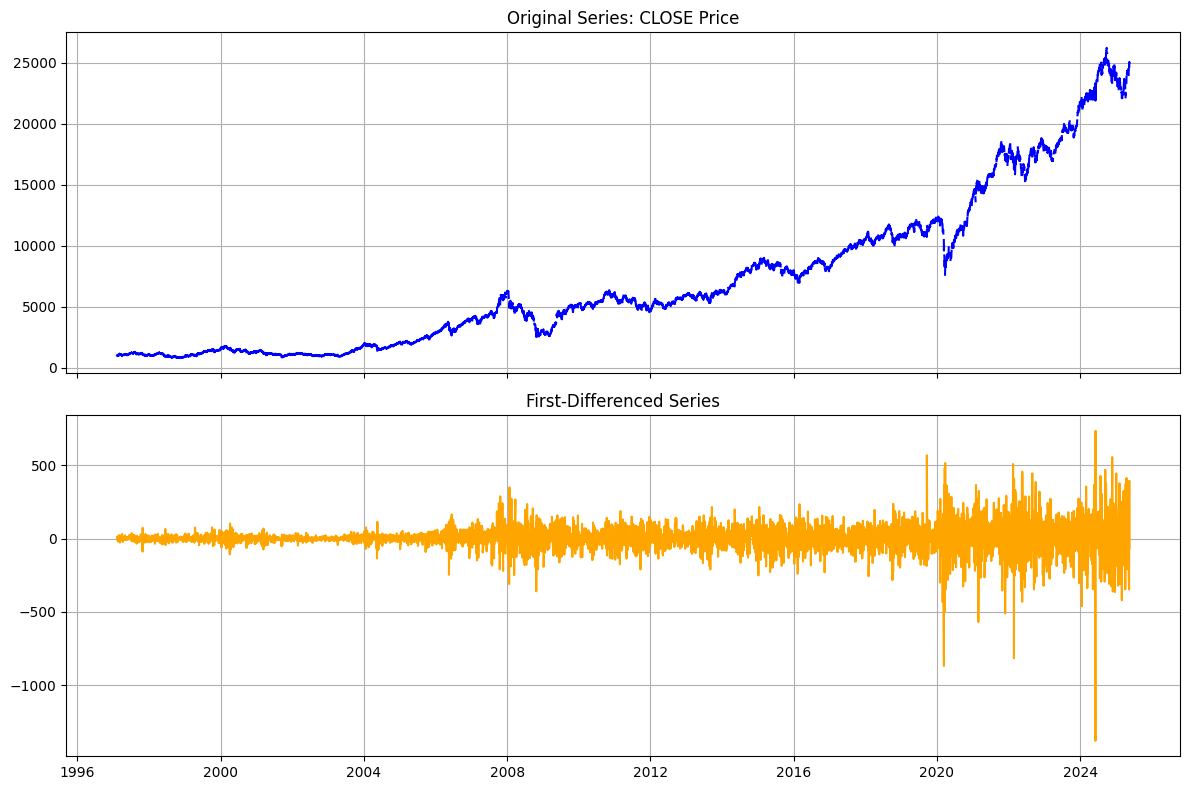

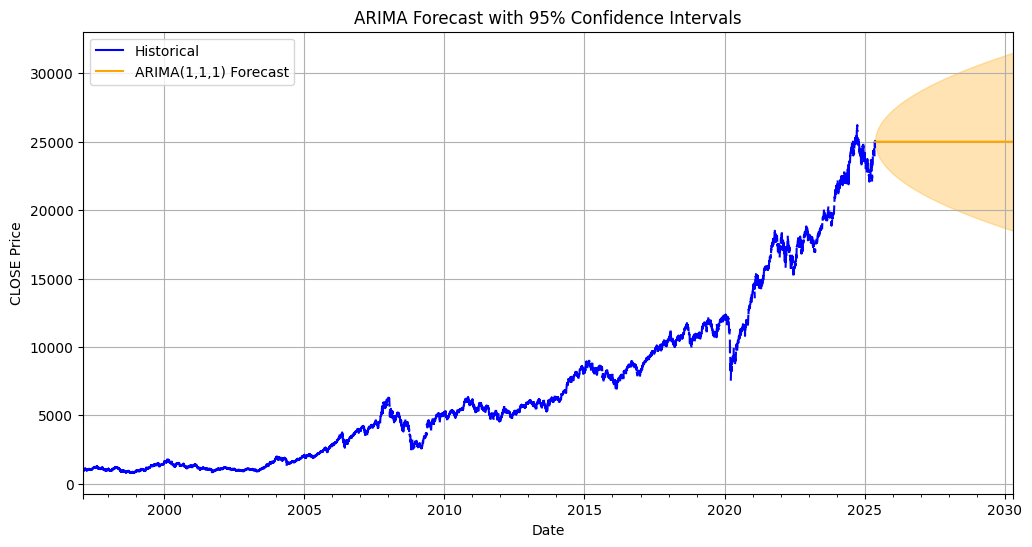

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts = df1['CLOSE']

# Check stationarity
result = adfuller(ts.dropna())
print('ADF Statistic:', result[0], 'p-value:', result[1])
if result[1] > 0.05:
    print("Series is non-stationary. Consider differencing.")

ts_diff = ts.diff().dropna()
result = adfuller(ts_diff)
print('ADF p-value after 1st diff:', result[1])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(ts, color='blue')
axes[0].set_title('Original Series: CLOSE Price')
axes[0].grid(True)

axes[1].plot(ts_diff, color='orange')
axes[1].set_title('First-Differenced Series')
axes[1].grid(True)

plt.tight_layout()
plt.show()

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA on the original series
model = ARIMA(ts, order=(1, 1, 1))
res = model.fit()

# Forecast next 180 days with intervals
forecast_obj = res.get_forecast(steps=1800)
fc = forecast_obj.predicted_mean
ci = forecast_obj.conf_int()

# Plot historical, forecast, and CIs
plt.figure(figsize=(12, 6))
ts.plot(label='Historical', color='blue')
fc.plot(label='ARIMA(1,1,1) Forecast', color='orange')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title('ARIMA Forecast with 95% Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CLOSE Price')
plt.legend()
plt.grid(True)
plt.show()


Importing plotly failed. Interactive plots will not work.


Index(['DATETIME', 'SYMBOL', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME',
       'PREVIOUS_CLOSE', 'CHANGE', 'CHANGE_PERCENT', 'LOW_CLOSE', 'HIGH_CLOSE',
       'TOTAL', 'GAP', 'INTERVAL'],
      dtype='object')


14:43:22 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 634.8181900523111


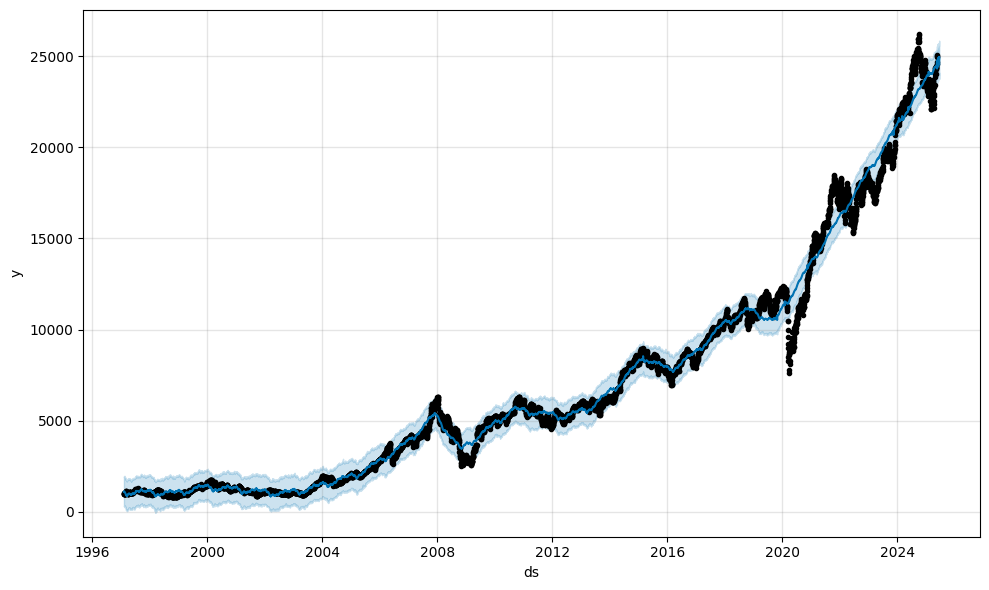

In [4]:
#!pip install prophet
import pandas as pd
from prophet import Prophet

df = pd.read_csv("D:/projects/zidio/NSE_Daily_indices_data.csv")

print(df.columns)

df = df[df['SYMBOL'] == 'NIFTY']

df['DATETIME'] = pd.to_datetime(df['DATETIME'],dayfirst=True)

prophet_df = df[['DATETIME', 'CLOSE']].rename(columns={'DATETIME': 'ds', 'CLOSE': 'y'})

model = Prophet()
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)

model.plot(forecast)

# Merge actual values and forecast
merged = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds')
merged.dropna(inplace=True)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mse)

print("Prophet RMSE:", rmse)



In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only the 'CLOSE' column and drop NaNs


data = df[['CLOSE']].dropna()

# Normalize the close prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape input to 3D for LSTM: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into training and test sets (80-20 split)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Reloading Tuner from tuner_dir\lstm_tuning\tuner0.json
Best hyperparameters: {'units1': 192, 'num_lstm_layers': 0, 'l2': 0.0001, 'dropout1': 0.1, 'recurrent_dropout1': 0.2, 'learning_rate': 0.001, 'units2': 128, 'dropout2': 0.2, 'recurrent_dropout2': 0.2}


C:\Users\ADMIN\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - loss: 0.1603 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - loss: 0.0412 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - loss: 0.0292 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - loss: 0.0222 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - loss: 0.0172 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - loss: 0.0140 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 0.0114 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.0098 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 9/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - loss: 0.0079 - val_loss: 0.0056 - learn

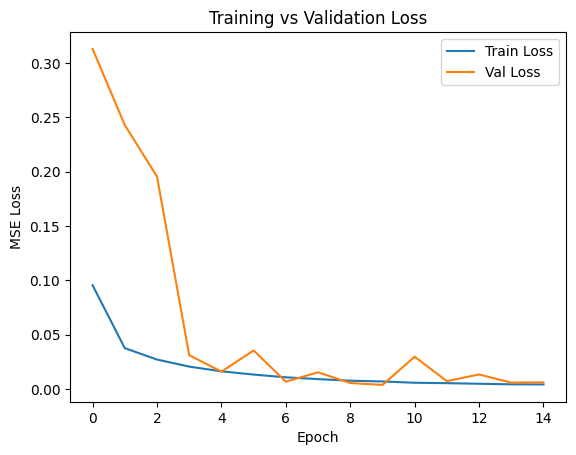

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
from tensorflow.keras.layers import BatchNormalization

# --- Function to build model for Keras Tuner ---
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        128,
        input_shape=(X_train.shape[1],1),
        dropout=0.2, recurrent_dropout=0.2,
        kernel_regularizer=l2(1e-3),
        recurrent_regularizer=l2(1e-3)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model

# ---  Hyperparameter search ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='lstm_tuning'
)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlp = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

tuner.search(X_train, y_train,
             epochs=30,
             batch_size = 32,
             validation_data=(X_test, y_test),
             callbacks=[es, rlp],
             verbose=1)

best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hps.values)

# ---  Build final model with best hyperparameters ---
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es, rlp],
    verbose=1
)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step


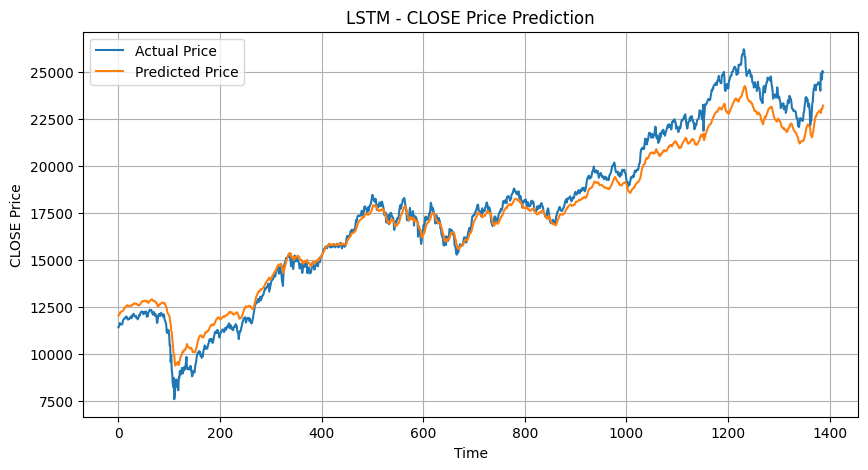

In [21]:
predicted = model.predict(X_test)

# Inverse transform predictions and actual values
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("LSTM - CLOSE Price Prediction")
plt.xlabel("Time")
plt.ylabel("CLOSE Price")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate test predictions
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 820.67
Mean Absolute Error (MAE): 658.80
